Import libraries

In [13]:
# Import libraries if required.
!pip3 install --upgrade pip
!pip3 install pandas
!pip3 install scipy
!pip3 install seaborn

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [14]:
import pandas as pd
import seaborn as sns
from scipy import stats

all helper functions for data cleaning

In [47]:
# to convert a value to any other value with a default specification
def tryconvert(value, default, *types):
    for t in types:
        try:
            return t(value)
        except (ValueError, TypeError):
            continue
    return default



Load and process mitigation data

In [53]:
#https://www.fema.gov/openfema-data-page/hazard-mitigation-assistance-mitigated-properties-v2
#https://www.fema.gov/openfema-data-page/hazard-mitigation-assistance-projects-v2
mitigated_property = pd.read_csv("HazardMitigationAssistanceMitigatedProperties.csv", sep = ',')
mitigated_project = pd.read_csv("HazardMitigationAssistanceProjects.csv", sep = ',')

#select important columns
mitigated_project = mitigated_project[['projectIdentifier', 'projectType', 'projectTitle', 'numberOfProperties', 'numberOfFinalProperties', 'costSharePercentage', 'projectAmount','benefitCostRatio', 'netValueBenefits']]

#join data sets on project identifier
mitigation_data = mitigated_property.merge(mitigated_project, how = 'inner', on = 'projectIdentifier')

# filtering invalid zip codes
mitigation_data= mitigation_data[mitigation_data['zip'].apply(lambda x: str(x).isdigit())]

# convert datatypes
mitigation_data = mitigation_data.astype({'zip': 'int64'})

mitigation_data.head()

,disasterNumber,region,stateNumberCode,state,countyCode,county,city,zip,projectIdentifier,propertyAction,...,subgranteeTribalIndicator,id,projectType,projectTitle,numberOfProperties_y,numberOfFinalProperties,costSharePercentage,projectAmount,benefitCostRatio,netValueBenefits
0,1604.0,4.0,28.0,Mississippi,27.0,Coahoma,ALLIGATOR,38720,DR-1604-0002-R,Safe Room/Wind Shelter,...,No,6176dfd34f1519431d0550bf,206.1: Safe Room (Tornado and Severe Wind Shel...,NaN,8043,8043,1.0,20069278.0,0.0,0.0
1,1604.0,4.0,28.0,Mississippi,115.0,Pontotoc,PONTOTOC,38863,DR-1604-0002-R,Safe Room/Wind Shelter,...,No,6176dfd34f1519431d0550c5,206.1: Safe Room (Tornado and Severe Wind Shel...,NaN,8043,8043,1.0,20069278.0,0.0,0.0
2,1604.0,4.0,28.0,Mississippi,57.0,Itawamba,GOLDEN,38847,DR-1604-0002-R,Safe Room/Wind Shelter,...,No,6176dfd34f1519431d0550d8,206.1: Safe Room (Tornado and Severe Wind Shel...,NaN,8043,8043,1.0,20069278.0,0.0,0.0
3,1604.0,4.0,28.0,Mississippi,29.0,Copiah,WEST,39192,DR-1604-0002-R,Safe Room/Wind Shelter,...,No,6176dfd34f1519431d0550f6,206.1: Safe Room (Tornado and Severe Wind Shel...,NaN,8043,8043,1.0,20069278.0,0.0,0.0
4,1604.0,4.0,28.0,Mississippi,115.0,Pontotoc,ECRU,38841,DR-1604-0002-R,Safe Room/Wind Shelter,...,No,6176dfd34f1519431d05510b,206.1: Safe Room (Tornado and Severe Wind Shel...,NaN,8043,8043,1.0,20069278.0,0.0,0.0


In [54]:
# printing mitigation data schema
mitigation_data.dtypes

disasterNumber               float64
region                       float64
stateNumberCode              float64
state                         object
countyCode                   float64
county                        object
city                          object
zip                            int64
projectIdentifier             object
propertyAction                object
structureType                 object
typeOfResidency               object
actualAmountPaid             float64
programFy                      int64
dateInitiallyApproved        float64
dateApproved                 float64
dateClosed                   float64
status                        object
programArea                   object
title                        float64
type                          object
numberOfProperties_x           int64
numberOfRecords              float64
damageCategory                object
granteeTribalIndicator        object
subgranteeTribalIndicator     object
id                            object
p

In [55]:
# printing metrics for mitigation data
print("number of rows: " + str(mitigation_data.shape[0]))
print("number of cols: " + str(mitigation_data.shape[1]))

number of rows: 64326
number of cols: 35


Load and process flood data

In [29]:
flood_data = pd.read_csv("flood_clustered_dataset.csv", sep = ',')
flood_data = flood_data.rename(columns={"zipcode": "zip"})
flood_data.head()

,id,zip,pct_water,count_property,pct_fs_risk_2020_5,pct_fs_risk_2050_5,pct_fs_risk_2020_100,pct_fs_risk_2050_100,pct_fs_risk_2020_500,pct_fs_risk_2050_500,...,region,region_code,region2,region2_code,latitude,longitude,total_population,usda_region,pop_density,cluster_label
0,0,36083,0.008302,8936,4.8,5.1,8.1,8.5,9.5,9.8,...,Macon,87.0,NaN,NaN,32.4316,-85.6861,7316,Southeast,11.089038,37
1,1,35441,0.048178,1891,7.9,14.5,41.9,43.3,45.6,45.8,...,Hale,65.0,NaN,NaN,32.8553,-87.7219,972,Southeast,5.623359,3
2,2,35051,0.018999,4784,6.9,7.2,13.4,13.8,15.5,15.9,...,Shelby,117.0,NaN,NaN,33.1770,-86.6161,9838,Southeast,35.106068,27
3,3,35121,0.014148,11527,8.2,8.5,13.1,13.5,15.0,15.6,...,Blount,9.0,NaN,NaN,33.9259,-86.4741,16123,Southeast,43.255813,27
4,4,35058,0.017164,5868,3.4,3.6,5.3,5.4,6.2,6.4,...,Cullman,43.0,NaN,NaN,34.2098,-86.7520,8630,Southeast,48.472275,28


In [60]:
# printing flood data schema
flood_data.dtypes

id                        int64
zip                       int64
pct_water               float64
count_property            int64
pct_fs_risk_2020_5      float64
pct_fs_risk_2050_5      float64
pct_fs_risk_2020_100    float64
pct_fs_risk_2050_100    float64
pct_fs_risk_2020_500    float64
pct_fs_risk_2050_500    float64
place_name               object
state_name               object
region                   object
region_code             float64
region2                  object
region2_code            float64
latitude                float64
longitude               float64
total_population          int64
usda_region              object
pop_density             float64
cluster_label             int64
dtype: object

In [25]:
# printing metrics for flood data
print("number of rows: " + str(flood_data.shape[0]))
print("number of cols: " + str(flood_data.shape[1]))
print("column names: " + str(list(flood_data.columns)))

number of rows: 32146
number of cols: 22
column names: ['id', 'zipcode', 'pct_water', 'count_property', 'pct_fs_risk_2020_5', 'pct_fs_risk_2050_5', 'pct_fs_risk_2020_100', 'pct_fs_risk_2050_100', 'pct_fs_risk_2020_500', 'pct_fs_risk_2050_500', 'place_name', 'state_name', 'region', 'region_code', 'region2', 'region2_code', 'latitude', 'longitude', 'total_population', 'usda_region', 'pop_density', 'cluster_label']


combining mitigation and flood data

In [58]:
# combining mitigation and flood data
mitigion_and_flood_data = flood_data.merge(mitigation_data, how = 'inner', on = 'zip')
mitigion_and_flood_data.head()

,id_x,zip,pct_water,count_property,pct_fs_risk_2020_5,pct_fs_risk_2050_5,pct_fs_risk_2020_100,pct_fs_risk_2050_100,pct_fs_risk_2020_500,pct_fs_risk_2050_500,...,subgranteeTribalIndicator,id_y,projectType,projectTitle,numberOfProperties_y,numberOfFinalProperties,costSharePercentage,projectAmount,benefitCostRatio,netValueBenefits
0,0,36083,0.008302,8936,4.8,5.1,8.1,8.5,9.5,9.8,...,No,6176dfd54f1519431d0566b2,206.1: Safe Room (Tornado and Severe Wind Shel...,NaN,46,34,0.67,200728.0,1.371,21420.0
1,0,36083,0.008302,8936,4.8,5.1,8.1,8.5,9.5,9.8,...,NaN,6176dfd64f1519431d057fd7,206.1: Safe Room (Tornado and Severe Wind Shel...,NaN,587,405,0.75,1804955.0,8.801,3274.0
2,0,36083,0.008302,8936,4.8,5.1,8.1,8.5,9.5,9.8,...,No,6176dfd54f1519431d057fb5,206.1: Safe Room (Tornado and Severe Wind Shel...,NaN,8,8,0.73,41695.0,1.371,21420.0
3,0,36083,0.008302,8936,4.8,5.1,8.1,8.5,9.5,9.8,...,No,6176dfdd4f1519431d06385c,206.2: Safe Room (Tornado and Severe Wind Shel...,NaN,1,1,0.75,80047.0,2.015,212674.0
4,1,35441,0.048178,1891,7.9,14.5,41.9,43.3,45.6,45.8,...,No,6176dfd74f1519431d059a6c,206.1: Safe Room (Tornado and Severe Wind Shel...,NaN,69,37,0.70,181966.0,1.371,21420.0


Define functions

In [3]:
#list of zipcodes (clusters) will be determined by Li and Daniel
def filter_zip(lst, data):
    '''This function takes in a list of zipcodes(strings) with similar natural disaster risks
    and returns a data frame with mitigation information for those specified areas'''
    filt = data['zip'].isin(lst)
    return data[filt]

In [4]:
#test function
lst = ['32503','38863']
test = filter_zip(lst, data)

Explore data

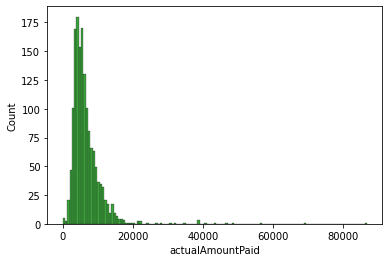

In [5]:
#distribution of money paid to each property in the selected area
ax = sns.histplot(data = test, x = 'actualAmountPaid', color = 'green')

(0.9746446566753605, 0.0)

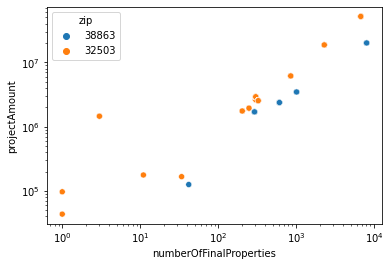

In [6]:
#correlation between number of properties and cost of project
ax = sns.scatterplot(x="numberOfFinalProperties", y="projectAmount", data=test, hue = 'zip')
ax.set_xscale('log')
ax.set_yscale('log')
stats.pearsonr(test['numberOfFinalProperties'], test['projectAmount'])

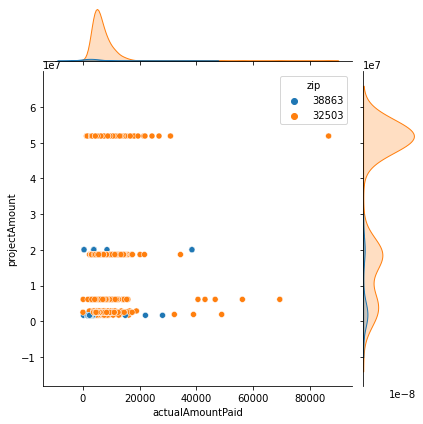

In [10]:
ax = sns.jointplot(x='actualAmountPaid', y="projectAmount", data=test, hue = 'zip')

<AxesSubplot:>

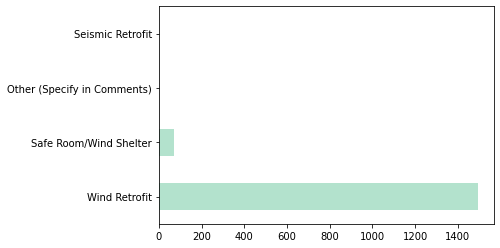

In [7]:
test['propertyAction'].value_counts().head(5).plot(kind='barh', colormap = 'Pastel2')

<AxesSubplot:>

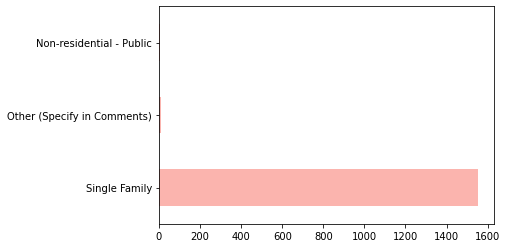

In [8]:
test['structureType'].value_counts().head(5).plot(kind='barh', colormap = 'Pastel1')

<AxesSubplot:>

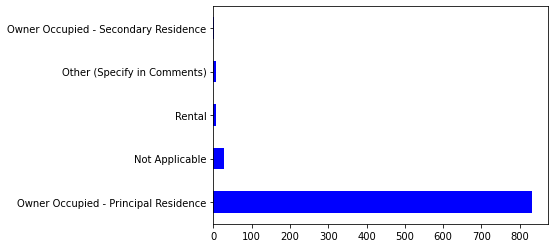

In [9]:
test['typeOfResidency'].value_counts().head(5).plot(kind='barh', color = 'blue')